#Convolutional Neural Networks

##Transfer Learning
Se refiere a usar modelos que ya han sido entrenados y nosotros aprovechamos ese entrenamiento para alguna aplicación similar nuestra.
Se usa el modelo para aplicar un nueo entrenamiento que agregue alguna característica.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

#Importar el dataset
import tensorflow_datasets as tfds

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs',
                                                            split=['train[:80%]', 'train[80%:90%]','train[90%:]'],
                                                            with_info=True,
                                                            as_supervised=True,)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteGXYR6O/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
#Función para recuperar el label de cada imagen
get_label_name = metadata.features['label'].int2str


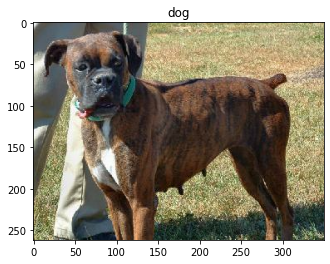

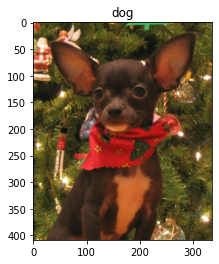

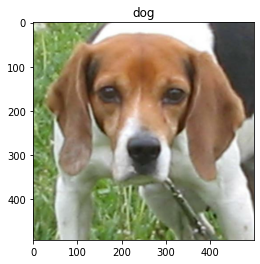

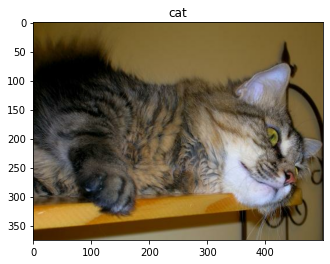

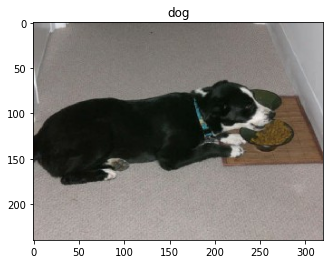

In [ ]:
#Prueba de la función
for image, label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

##Pre procesamiento

Todas las imágenes deben tener el mismo tamaño para entrar a la red neuronal

Las imágenes tienen 3 dimensiones de profundidad, pues están a color

In [ ]:
#Todas las imágenes a 160x160
IMG_SIZE = 160
def format_example(image, label):
  image = tf.cast(image, tf.float32) # Pasar los valores de la imagen de entero a flotante
  image = (image/127.5) - 1 #Normalizar los valores de los pixeles.
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
#map me permite ejecutar una función a través de todo el dataset, se usa por ejemplo cuando queremos aplicar una modificación de todos los datos
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32 #Batch size es cada cuánto se hará una actualización de las imágenes
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
#Verificar eñ nuevo tamaño de las imágenes
for img, label in raw_train.take(2):
  print('Original_size: ', img.shape)

for img, label in train.take(2):
  print('Original_size: ', img.shape)

Original_size:  (262, 350, 3)
Original_size:  (409, 336, 3)
Original_size:  (160, 160, 3)
Original_size:  (160, 160, 3)


##Modelando la Red Neuronal

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3) #Se ingresa la medida de la imágen y dimensión

In [ ]:
#Crear el modelo base
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top = False, weights='imagenet')
base_model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [ ]:
#Freeze del modelo base
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
prediction_layer = keras.layers.Dense(1, activation = 'sigmoid')

In [ ]:
#Juntar las 3 capas
# Layer 1 = base_model (MobileNetV2), Layer 2 = Global average pollin (Flattening), Layer 3 = Dense layer (Donde se encuentra el procesamiento neuronal y la salida de la función sigmoide)
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#Hiperparámetros
learning_rate = 0.0001

In [ ]:
model.compile(optimizer= tf.keras.optimizers.RMSprop(lr = learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
#Hiperparámetros
initial_epochs = 3
validation_steps = 20

In [ ]:
history = model.fit(train_batches, epochs = initial_epochs, validation_data = validation_batches)
acc = history.history['accuracy']
print(acc)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


582/582 [==============================] - 438s 741ms/step - loss: 0.2503 - accuracy: 0.8994 - val_loss: 0.0920 - val_accuracy: 0.9733
Epoch 2/3
582/582 [==============================] - 406s 694ms/step - loss: 0.0728 - accuracy: 0.9775 - val_loss: 0.0650 - val_accuracy: 0.9781
Epoch 3/3
582/582 [==============================] - 409s 699ms/step - loss: 0.0580 - accuracy: 0.9811 - val_loss: 0.0571 - val_accuracy: 0.9798
[0.8994089365005493, 0.9774852395057678, 0.9811391830444336]


In [ ]:
model.save("dogs_vs_cats.h5") #guardar modelo

In [ ]:
new_model = tf.keras.models.load_model("dogs_vs_cats.h5") #Cargar el modelo

In [ ]:
result = model.evaluate(test_batches) ##Se hace el testeo, aplica el modelo sobre nuevos datos que no se usaron en el entrenamiento, es decir sobre los datos de testeo en (test_batches)
dict(zip(new_model.metrics_names, result)) #Guardar el costo, accuracy en diccionario

73/73 [==============================] - 47s 631ms/step - loss: 0.0525 - accuracy: 0.9862


{'loss': 0.052523985505104065, 'accuracy': 0.9862424731254578}

Tanto el costo y accuracy de testeo, validation y normal son muy parecidos, o cual es una buena señal.

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 64ms/step


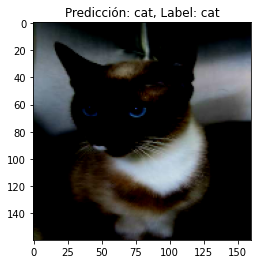

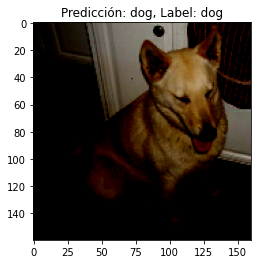

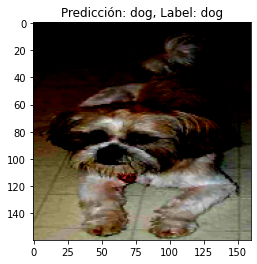

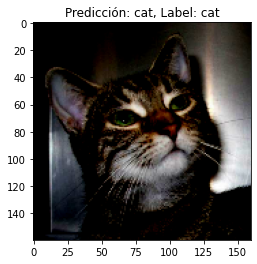

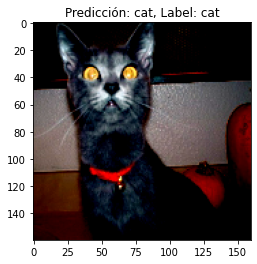

In [ ]:
for image, label in test.take(5):
  image = tf.expand_dims(image, axis=0)
  y = new_model.predict(image)

  if(y>=0.5):
    pred = 'dog'
  else:
    pred = 'cat'
  plt.figure()
  plt.imshow(tf.squeeze(image))
  plt.title("Predicción: "+pred+", Label: "+ get_label_name(label))

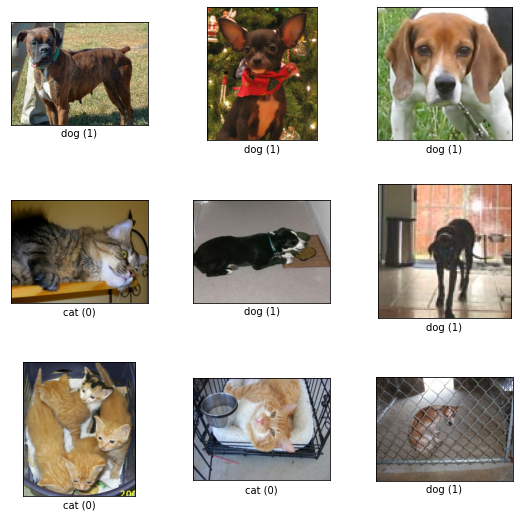

In [ ]:
fig = tfds.show_examples(raw_train, metadata)

In [ ]:
#Creae matriz de confusión
y_pred = []
y_true = []

for image_batch, label_batch in test_batches:
  y_true.append(label_batch)

  preds = new_model.predict(image_batch)
  y_pred.append(np.round(preds))

1/1 [==============================] - 0s 388ms/step


In [ ]:
correct_labels = tf.concat([val for val in y_true], axis = 0) #El primer parámetro es para la compresión de lista
predicted_labels = tf.concat([val for val in y_pred], axis = 0)

In [ ]:
tf.math.confusion_matrix(
    correct_labels,
    predicted_labels
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1145,   15],
       [  17, 1149]], dtype=int32)>

,image,label
0,,1 (dog)
1,,1 (dog)
2,,1 (dog)
3,,0 (cat)
4,,1 (dog)

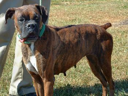
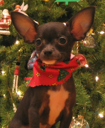
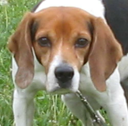
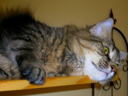
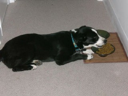

In [ ]:
tfds.as_dataframe(raw_train.take(5),metadata)